# 7. Final Models Comparison and Ensembling

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore') # Disable warnings due to versioning errors

import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import joblib
from FeatureSelectionUtils import import_final_selected_features_from_csv 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from Utils import plotMetricsGraphComparison 

## Import Train and Test Datasets

In [2]:
# Load in feature engineered data
X_train = pd.read_csv('Data/X_train_engineered.csv')
X_test = pd.read_csv('Data/X_test_engineered.csv')
Y_train = pd.read_csv('Data/y_train_undersampled_data.csv')
Y_test = pd.read_csv('Data/y_test.csv')

print("Train Set :", Y_train.shape, X_train.shape)
print("Test Set  :", Y_test.shape, X_test.shape)

Train Set : (20392, 1) (20392, 75)
Test Set  : (8176, 1) (8176, 75)


## Comparing the Best Classification Models
This final notebook is used to compare the best models after we individually tried to do feature engineering, feature selection and hyperparameter tuning to the different classification techniques (e.g. SVM, Random Forest..), to obtain the best model for each classification technique.


The goal is to **compare and select the best model based on the improvements done on each individual models**.

### Load the best models and feature sets
We will load the best model from each classification models with the best feature selection and hyperparameter tuning and create a chart to compare them.

In [3]:
# Step 1: Load all the best model from each classification models with the best feature selection and hyperparameter tuning done
BestModels = {
    'Best Logistic Regression': joblib.load('FinalModels/BestLogisticRegression.pkl'),
    'Best KNN': joblib.load('FinalModels/BestKNN.pkl'),
    "Best SVM" : joblib.load('FinalModels/BestSVM.pkl'),
    'Best Decision Tree': joblib.load('FinalModels/BestDecisionTree.pkl'),
    'Best Random Forest': joblib.load('FinalModels/BestRandomForest.pkl'),
    'Best Adaboost': joblib.load('FinalModels/BestAdaboost.pkl'),
    'Best Gradient Boosting': joblib.load('FinalModels/BestGradientBoosting.pkl'),
    'Best LightGBM': joblib.load('FinalModels/BestLightGBM.pkl')
}

# Map each model to their corresponding feature selecction file
BestModels_featureselection_files = {
    'Best Logistic Regression': 'FinalModels/Feature_Selection/Best Logistic Regression_selected_features.csv',
    'Best KNN': 'FinalModels/Feature_Selection/Best KNN_selected_features.csv',
    "Best SVM" : 'FinalModels/Feature_Selection/Best SVM_selected_features.csv',
    'Best Decision Tree': 'FinalModels/Feature_Selection/Best Decision Tree_selected_features.csv',
    'Best Random Forest': 'FinalModels/Feature_Selection/Best Random Forest_selected_features.csv',
    'Best Adaboost': 'FinalModels/Feature_Selection/Best Adaboost_selected_features.csv',
    'Best Gradient Boosting': 'FinalModels/Feature_Selection/Best Gradient Boosting_selected_features.csv',
    'Best LightGBM': 'FinalModels/Feature_Selection/Best LightGBM_selected_features.csv'
}

# Step 2: Load feature selections and evaluate models
test_metrics = pd.DataFrame()
for model_name, model in BestModels.items():
    # Load the corresponding feature selection CSV
    feature_selection_csv_path = BestModels_featureselection_files[model_name]
    selected_features = import_final_selected_features_from_csv(feature_selection_csv_path)
    X_test_feature_selected = X_test[selected_features]
    
    # Predict the output based on our training and testing dataset
    Y_test_pred = model.predict(X_test_feature_selected)
    
    test_metric = {
        "Classification Model": model_name,
        "Accuracy": accuracy_score(Y_test, Y_test_pred),
        "Precision": precision_score(Y_test, Y_test_pred),
        "Recall": recall_score(Y_test, Y_test_pred),
        "F1 Score": f1_score(Y_test, Y_test_pred)
    }
    
    # Save to overall metrics dataframe for comparison later
    test_metrics = pd.concat([test_metrics, pd.DataFrame.from_records([test_metric])], ignore_index = True)

### Comparing the Best Classification Models After Individual Feature Selection and Hyperparameter Tuning

In [4]:
test_metrics

,Classification Model,Accuracy,Precision,Recall,F1 Score
0,Best Logistic Regression,0.809442,0.539092,0.508323,0.523256
1,Best KNN,0.787671,0.484411,0.498811,0.491506
2,Best SVM,0.808586,0.536223,0.514863,0.525326
3,Best Decision Tree,0.804428,0.525665,0.505351,0.515308
4,Best Random Forest,0.823386,0.582296,0.500595,0.538363
5,Best Adaboost,0.822162,0.582489,0.478597,0.525457
6,Best Gradient Boosting,0.827911,0.595024,0.511891,0.550336
7,Best LightGBM,0.829990,0.602098,0.511891,0.553342


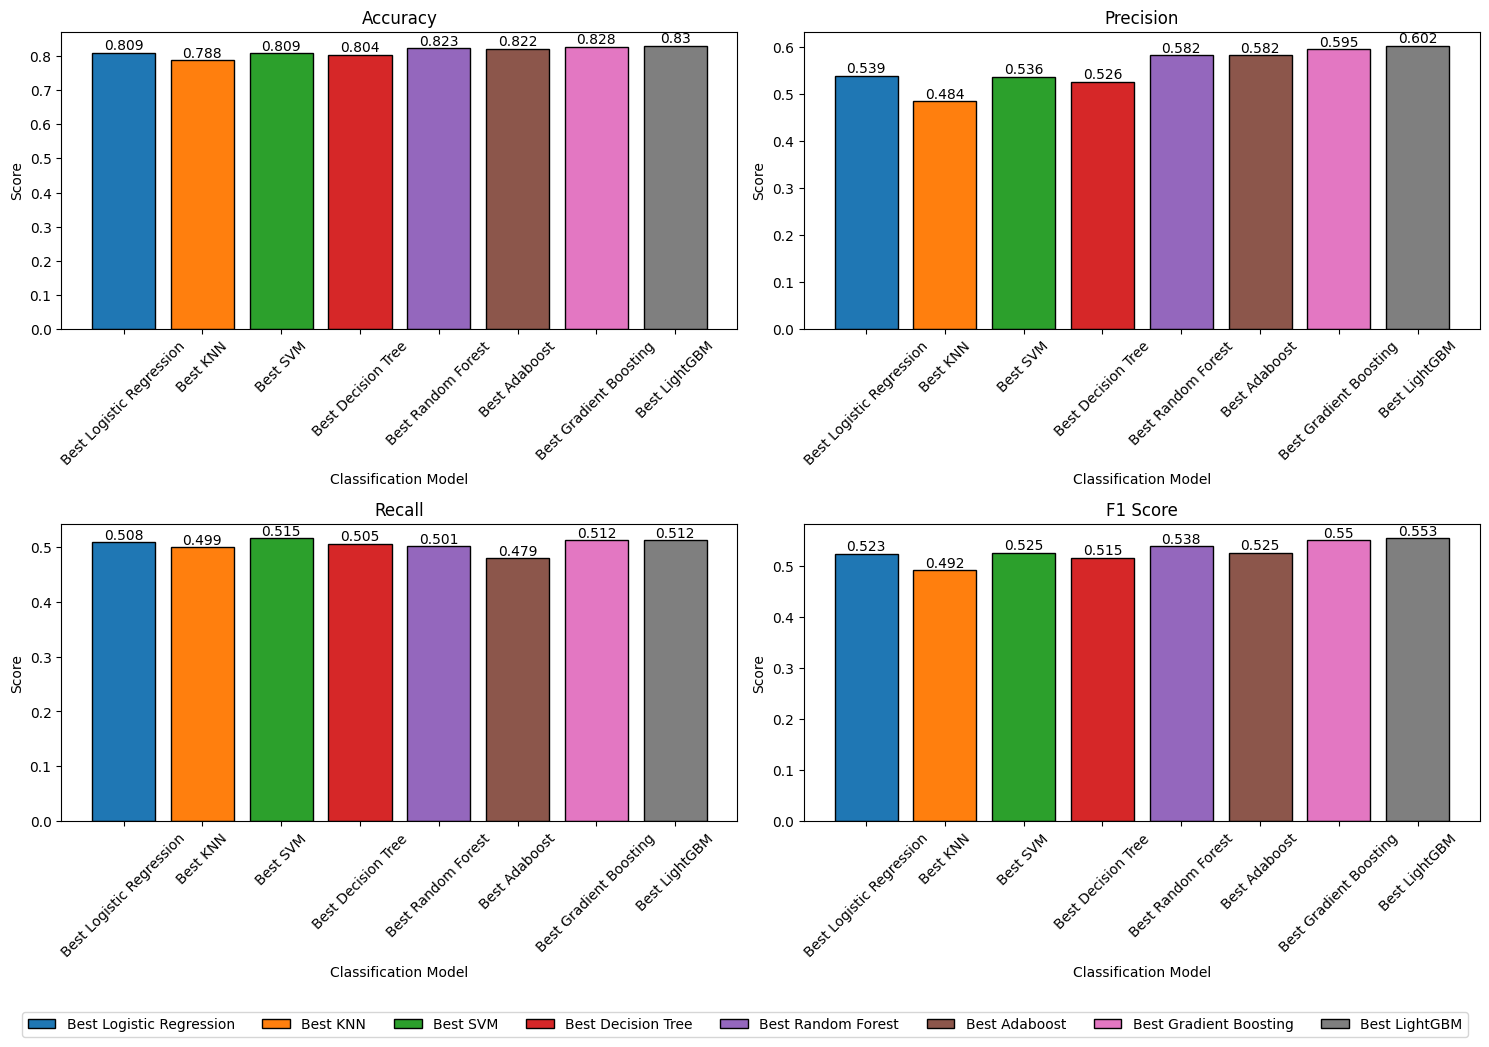

In [5]:
plotMetricsGraphComparison(test_metrics)

After retrieving the results from each model, we can see that the boosting models such as Gradient Boosting and LightGBM seems to outperform the others, having the highest accuracy and f1 score. In particular LightGBM has an accuracy score of 0.83 and F1 score of 0.553. 

Now, is there anyway we can improve the performance further? Could we make use of all the classification models we've used and try to combine their results to create a model? This can be done using manual ensembling with metamodels.

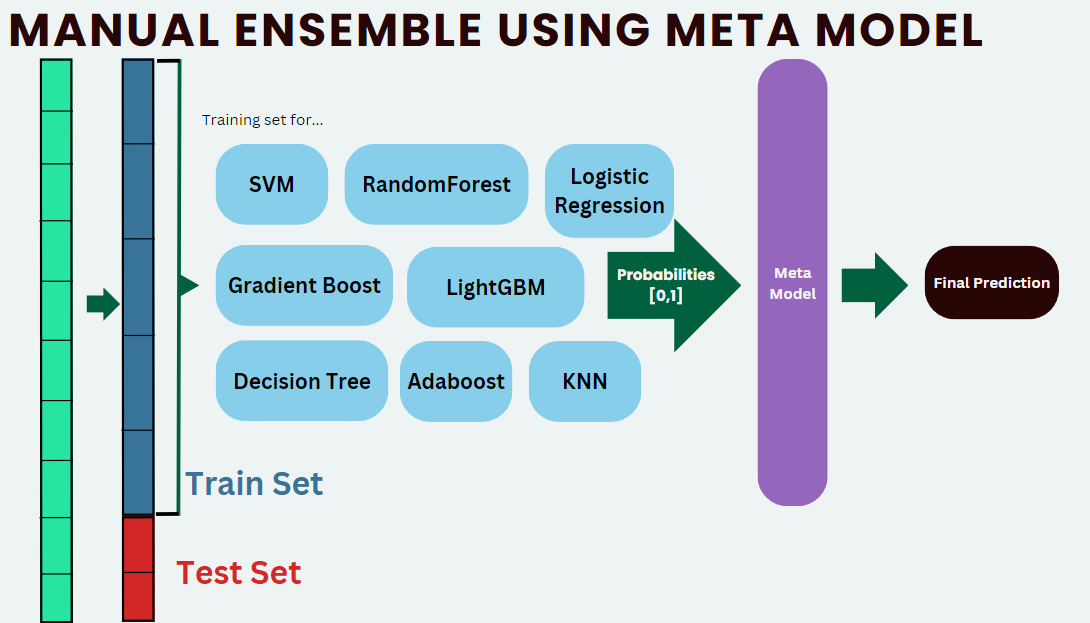

## Manual Ensembling
For manual ensembling with metamodels, we explored two implementations: 
- Manual stacking with K-fold cross-validation
- Sklearn's StackingClassifier.

In our manual implementation, we assembled previously trained models. Rather than predicting a binary class, these models were used to predict probabilities for each class. This resulted in a matrix of predictions which was then used to train meta-models, namely decision tree and logistic regression, to learn the optimal way to combine the base models' outputs for the final prediction.

### Loading of pre-trained models and selected features

In [6]:
models = [
    {
    "model" : joblib.load('FinalModels/BestRandomForest.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best Random Forest_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestDecisionTree.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best Decision Tree_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestGradientBoosting.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best Gradient Boosting_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestAdaboost.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best Adaboost_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestLightGBM.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best LightGBM_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestSVM.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best SVM_selected_features.csv')
    },
    {
    "model" : joblib.load('FinalModels/BestKNN.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best KNN_selected_features.csv')
    },
     {
    "model" : joblib.load('FinalModels/BestLogisticRegression.pkl'),
    "selected_features" : import_final_selected_features_from_csv('FinalModels/Feature_Selection/Best Logistic Regression_selected_features.csv')
    },
]

### Stacking with K-Fold

We will first attempt ensembling using stacking with K-fold. We will use a base level of multiple models to make predictions, and then use another model (meta_model) at a higher level to combine these predictions into a final output.

We will attempt to use an self-defined function before using libaries to conduct stacking

In [7]:
def stacking_with_kfold(X_train, Y_train, X_test, Y_test, models, n_folds=5, meta_model = LogisticRegression()):
    meta_X_train = np.zeros((X_train.shape[0], len(models)))
    meta_X_test = np.zeros((X_test.shape[0], len(models)))

    metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

    kf = KFold(n_splits=n_folds, shuffle=True, random_state=47)
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {fold+1}/{n_folds}")

        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        Y_train_fold, Y_val_fold = Y_train.iloc[train_index], Y_train.iloc[val_index]
        for i, model_info in enumerate(models):
            selected_features = model_info['selected_features']
            model = model_info['model']
            model.fit(X_train_fold[selected_features], Y_train_fold.values.ravel())
            meta_X_train[val_index, i] = model.predict_proba(X_val_fold[selected_features])[:, 1]

        for i, model_info in enumerate(models):
            model = model_info['model']
            selected_features = model_info['selected_features']
            y_val_pred = model.predict(X_val_fold[selected_features])
            acc = accuracy_score(Y_val_fold, y_val_pred)
            prec = precision_score(Y_val_fold, y_val_pred)
            rec = recall_score(Y_val_fold, y_val_pred)
            f1 = f1_score(Y_val_fold, y_val_pred)
            metrics = pd.concat([metrics, pd.DataFrame.from_dict([{
                'Model': type(model).__name__, 
                'Accuracy': acc, 
                'Precision': prec, 
                'Recall': rec, 
                'F1 Score': f1
            }])], ignore_index=True)
            print(f"{type(model).__name__} Validation Metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    meta_model.fit(meta_X_train, Y_train.values.ravel())
    
    for i, model_info in enumerate(models):
        model = model_info['model']
        selected_features = model_info['selected_features']
        meta_X_test[:, i] = model.predict_proba(X_test[selected_features])[:, 1]

    y_test_pred = meta_model.predict(meta_X_test)
    
    acc = accuracy_score(Y_test, y_test_pred)
    prec = precision_score(Y_test, y_test_pred)
    rec = recall_score(Y_test, y_test_pred)
    f1 = f1_score(Y_test, y_test_pred)
    metrics = pd.concat([metrics, pd.DataFrame.from_dict([{
                'Model':  'Stacked',
                'Accuracy': acc, 
                'Precision': prec, 
                'Recall': rec, 
                'F1 Score': f1
            }])], ignore_index=True)
    print(f"Stacked Test Metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

    return metrics

def print_model_comparison(model_df):
    meta_model_metrics = model_df[model_df['Model'] == 'Stacked']
    other_model_performance = model_df[model_df['Model'] != 'Stacked'].groupby('Model').mean()
    num_models = len(other_model_performance.index) + 1
    colors = plt.cm.viridis(np.linspace(0, 1, num_models))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    axes = axes.ravel()

    for i, metric in enumerate(metrics_to_plot):
        model_names = list(other_model_performance.index) + ['Stacked']
        metric_values = list(other_model_performance[metric]) + [meta_model_metrics[metric].values[0]]

        bars = axes[i].bar(model_names, metric_values, color=colors)

        for bar, value in zip(bars, metric_values):
            height = bar.get_height()
            axes[i].annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                             xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

        axes[i].set_ylim(min(metric_values) * 0.95, max(metric_values) * 1.05)

        axes[i].set_title(metric)
        axes[i].set_ylabel(metric)
        axes[i].set_xticks(range(len(model_names)))
        axes[i].set_xticklabels(model_names, rotation=45, ha='right')

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05))
    plt.tight_layout()
    plt.show()

#### Using logistic regression as the meta model

In [8]:
metrics_logistic_regression = stacking_with_kfold(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test, models=models, meta_model=LogisticRegression())
print(metrics_logistic_regression)

Fold 1/5
RandomForestClassifier Validation Metrics: Accuracy=0.8831, Precision=0.8997, Recall=0.8623, F1=0.8806
DecisionTreeClassifier Validation Metrics: Accuracy=0.8674, Precision=0.8780, Recall=0.8534, F1=0.8655
GradientBoostingClassifier Validation Metrics: Accuracy=0.8794, Precision=0.9010, Recall=0.8525, F1=0.8761
AdaBoostClassifier Validation Metrics: Accuracy=0.7877, Precision=0.7855, Recall=0.7917, F1=0.7886
LGBMClassifier Validation Metrics: Accuracy=0.8647, Precision=0.8843, Recall=0.8392, F1=0.8612
SVC Validation Metrics: Accuracy=0.8603, Precision=0.8739, Recall=0.8422, F1=0.8577
KNeighborsClassifier Validation Metrics: Accuracy=0.8598, Precision=0.8745, Recall=0.8402, F1=0.8570
LogisticRegression Validation Metrics: Accuracy=0.7973, Precision=0.8031, Recall=0.7877, F1=0.7953
Fold 2/5
RandomForestClassifier Validation Metrics: Accuracy=0.8870, Precision=0.8964, Recall=0.8700, F1=0.8830
DecisionTreeClassifier Validation Metrics: Accuracy=0.8632, Precision=0.8594, Recall=0.8

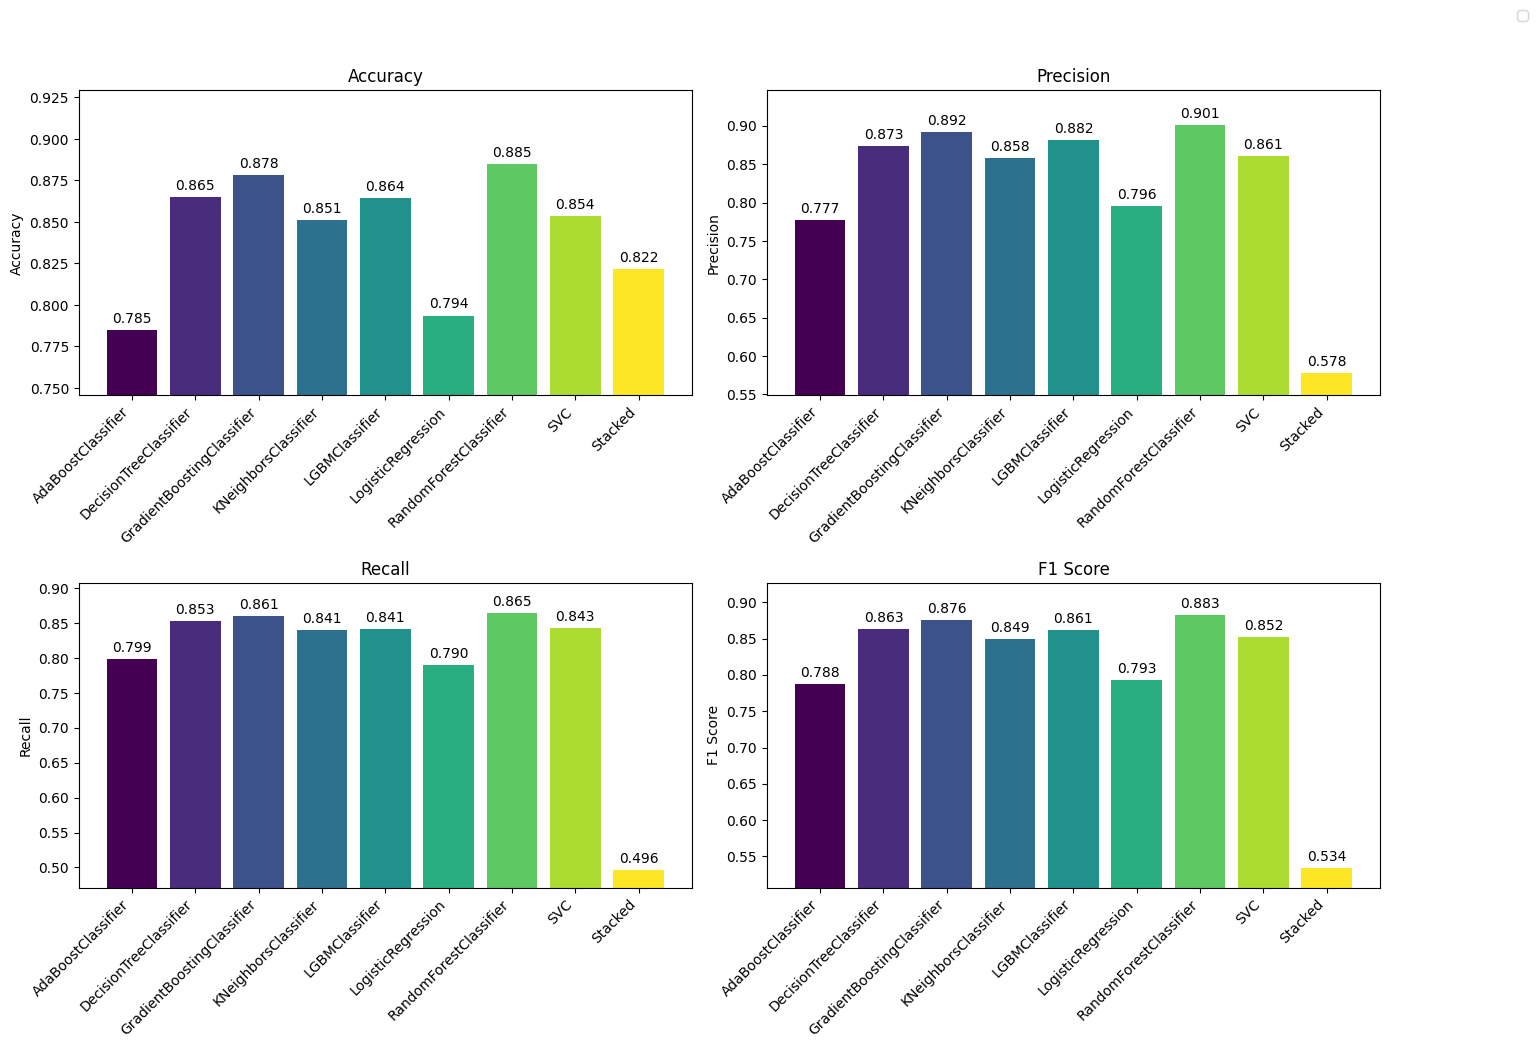

In [9]:
print_model_comparison(metrics_logistic_regression)

#### Using decision tree classifier as the mtea model

In [10]:
metrics_decision_tree = stacking_with_kfold(X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test, models=models, meta_model=DecisionTreeClassifier())
print(metrics_decision_tree)

Fold 1/5
RandomForestClassifier Validation Metrics: Accuracy=0.8831, Precision=0.8997, Recall=0.8623, F1=0.8806
DecisionTreeClassifier Validation Metrics: Accuracy=0.8674, Precision=0.8780, Recall=0.8534, F1=0.8655
GradientBoostingClassifier Validation Metrics: Accuracy=0.8794, Precision=0.9010, Recall=0.8525, F1=0.8761
AdaBoostClassifier Validation Metrics: Accuracy=0.7877, Precision=0.7855, Recall=0.7917, F1=0.7886
LGBMClassifier Validation Metrics: Accuracy=0.8647, Precision=0.8843, Recall=0.8392, F1=0.8612
SVC Validation Metrics: Accuracy=0.8603, Precision=0.8739, Recall=0.8422, F1=0.8577
KNeighborsClassifier Validation Metrics: Accuracy=0.8598, Precision=0.8745, Recall=0.8402, F1=0.8570
LogisticRegression Validation Metrics: Accuracy=0.7973, Precision=0.8031, Recall=0.7877, F1=0.7953
Fold 2/5
RandomForestClassifier Validation Metrics: Accuracy=0.8870, Precision=0.8964, Recall=0.8700, F1=0.8830
DecisionTreeClassifier Validation Metrics: Accuracy=0.8632, Precision=0.8594, Recall=0.8

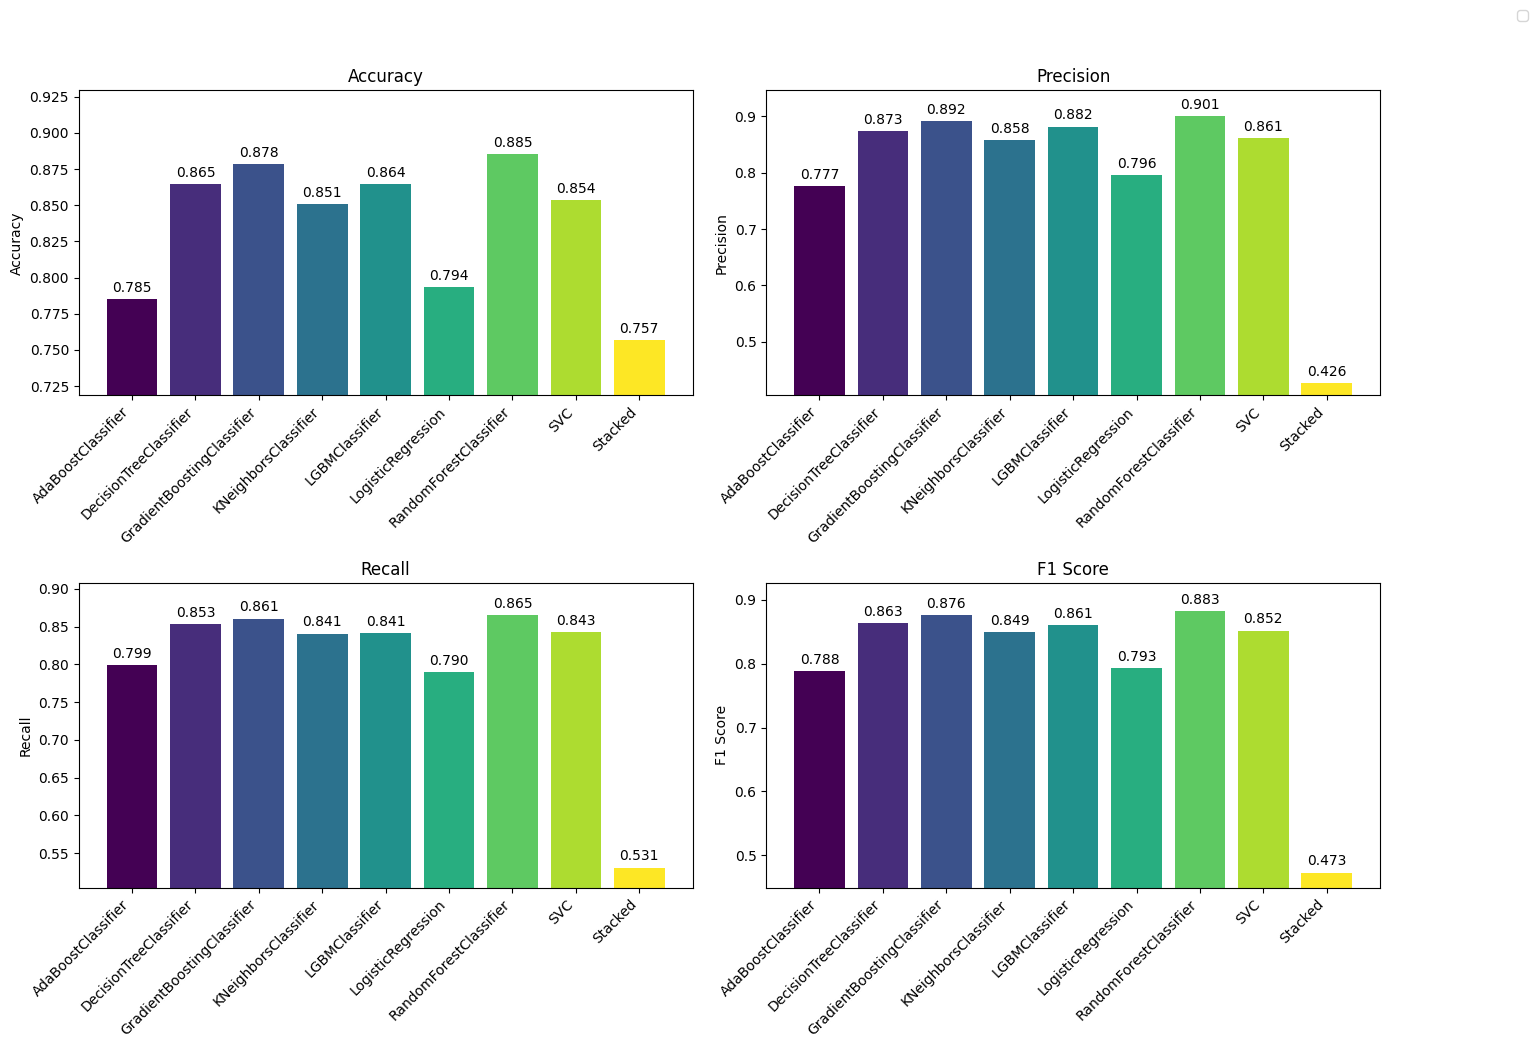

In [11]:
print_model_comparison(metrics_decision_tree)

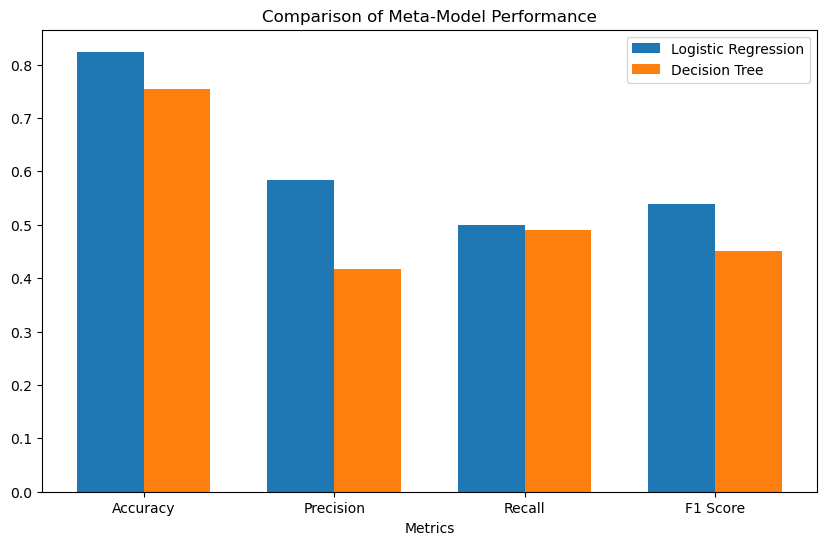

In [ ]:
meta_lr_metrics = metrics_logistic_regression[metrics_logistic_regression['Model'] == 'Stacked'].mean(numeric_only=True)
meta_dt_metrics = metrics_decision_tree[metrics_decision_tree['Model'] == 'Stacked'].mean(numeric_only=True)

labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
logistic_regression_scores = [meta_lr_metrics['Accuracy'], meta_lr_metrics['Precision'], meta_lr_metrics['Recall'], meta_lr_metrics['F1 Score']]
decision_tree_scores = [meta_dt_metrics['Accuracy'], meta_dt_metrics['Precision'], meta_dt_metrics['Recall'], meta_dt_metrics['F1 Score']]

x = np.arange(len(labels)) 
width = 0.35  

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, logistic_regression_scores, width, label='Logistic Regression')
rects2 = ax.bar(x + width/2, decision_tree_scores, width, label='Decision Tree')

ax.set_xlabel('Metrics')
ax.set_title('Comparison of Meta-Model Performance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

#### Analysis

It can be seen that there is a decrease in the score of the meta model accross all matrices.

A possible explaination is that stacking performance heavily relies on the diversity and accuracy of the base models. If the base models are too similar, have high bias, their ensemble prediction won't necessarily enhance performance. It might even degrade if the errors from the base models correlate.

### StackingClassifier from Sklearn

We will now attempt to use the StackingClassifier library from Sklearn to ensemble our models

In [12]:
estimators = [
     ('RandomForest',joblib.load('FinalModels/BestRandomForest.pkl')),
     ("DecisionTree", joblib.load('FinalModels/BestDecisionTree.pkl')),
     ("Adaboost",joblib.load('FinalModels/BestAdaboost.pkl')),
     ("GradientBoost",joblib.load('FinalModels/BestGradientBoosting.pkl')),
     ("LightGBM",joblib.load('FinalModels/BestLightGBM.pkl')),
     ('Best KNN', joblib.load('FinalModels/BestKNN.pkl')),
     ('Best Logistic Regression', joblib.load('FinalModels/BestLogisticRegression.pkl')),
     ('Best SVM', joblib.load('FinalModels/BestSVM.pkl'))
]

#### Using logistic regression has the meta model

In [13]:
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
clf.fit(X_train, Y_train.values.ravel())
y_pred_lr = clf.predict(X_test)

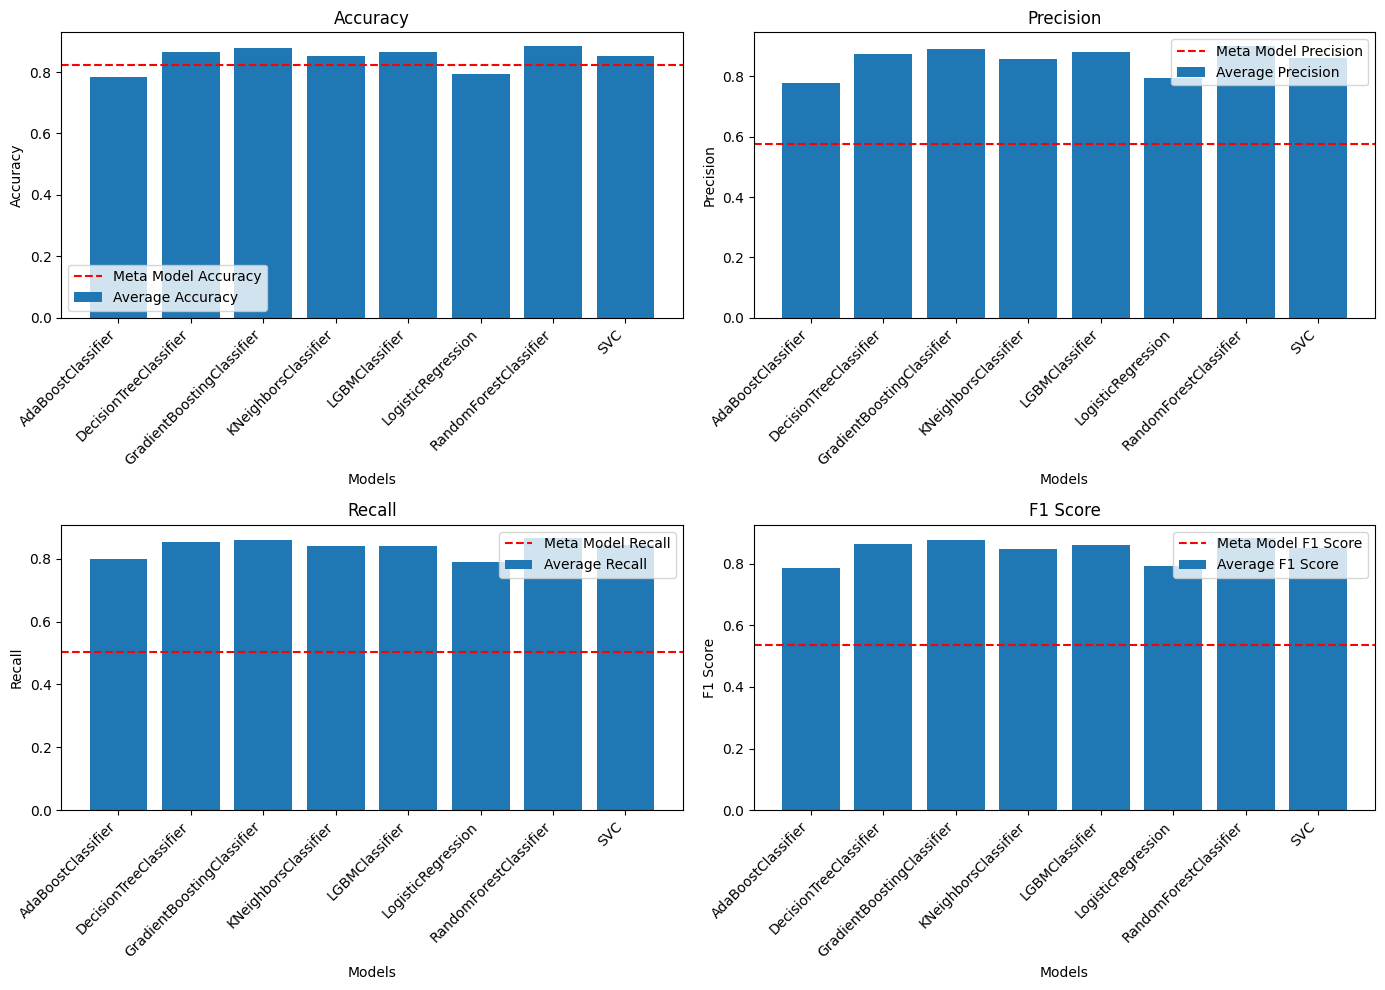

In [16]:
meta_model_metrics_lr = pd.DataFrame.from_dict([{
                'Model':  'Stacked',
                'Accuracy': accuracy_score(Y_test.values.ravel(),y_pred_lr),
                'Precision': precision_score(Y_test.values.ravel(),y_pred_lr), 
                'Recall': recall_score(Y_test.values.ravel(),y_pred_lr), 
                'F1 Score': f1_score(Y_test.values.ravel(),y_pred_lr)}])
model_performance = metrics_logistic_regression[metrics_logistic_regression['Model'] != 'Stacked'].groupby('Model').mean()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
axes = axes.ravel()
model_names = list(model_performance.index)

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(model_performance.index, model_performance[metric], label='Average ' + metric)
    axes[i].axhline(y=meta_model_metrics_lr[metric].values[0], color='r', linestyle='--', label='Meta Model ' + metric)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Models')
    axes[i].set_xticklabels(model_performance.index, rotation=45, ha='right')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Using decision tree classifier as the meta model

In [14]:
clf = StackingClassifier(
    estimators=estimators,
    final_estimator=DecisionTreeClassifier()
)
clf.fit(X_train, Y_train.values.ravel())
y_pred_dt = clf.predict(X_test)

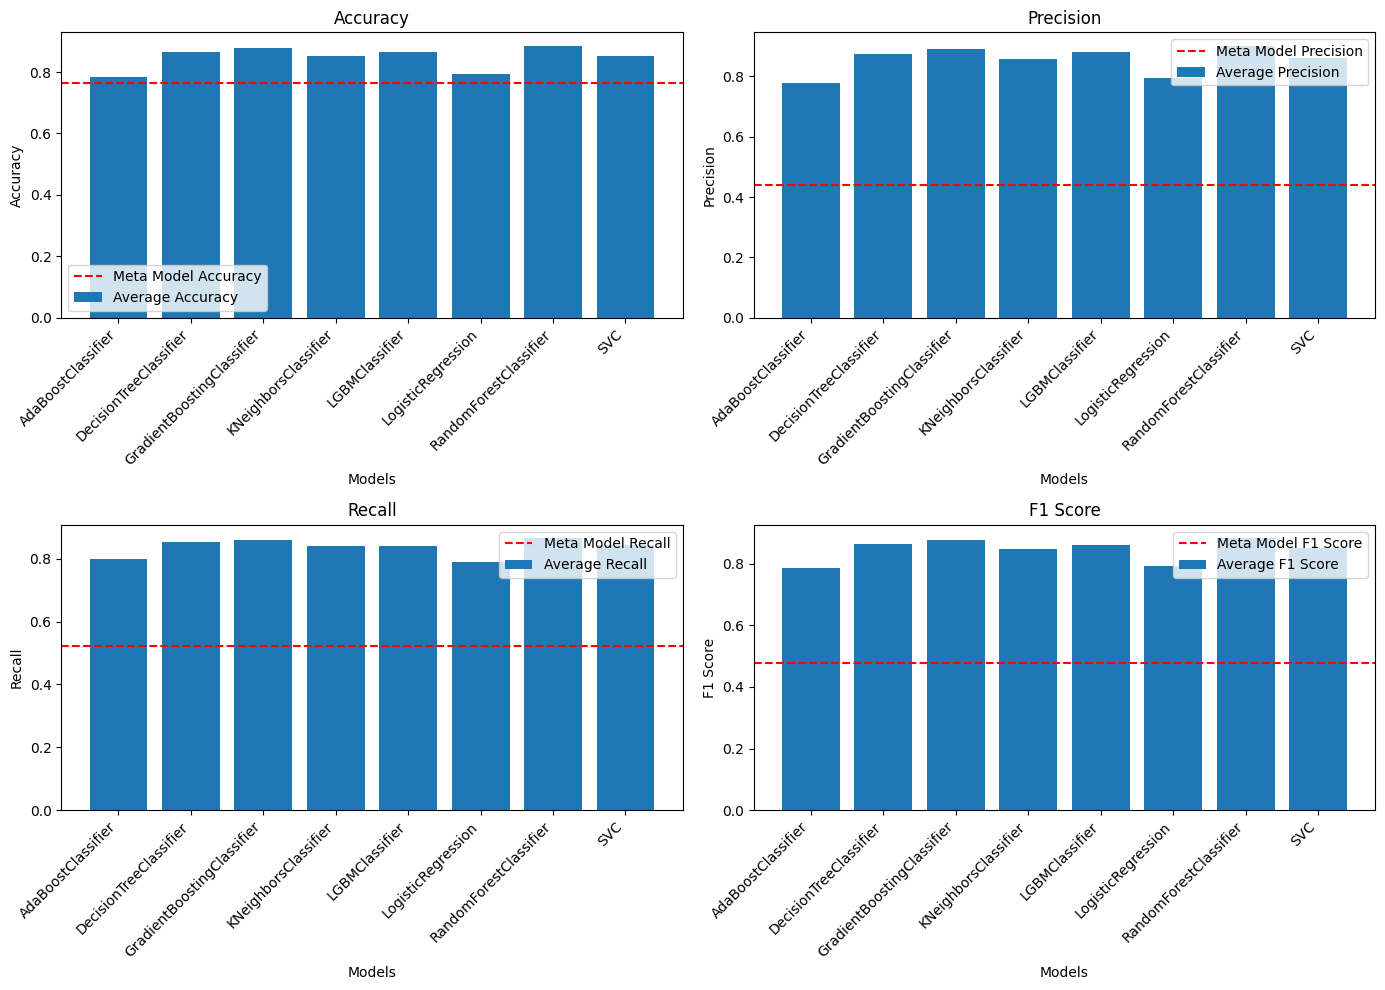

In [17]:
meta_model_metrics_dt = pd.DataFrame.from_dict([{
                'Model':  'SKlearn Logistic Regression',
                'Accuracy': accuracy_score(Y_test.values.ravel(),y_pred_dt),
                'Precision': precision_score(Y_test.values.ravel(),y_pred_dt), 
                'Recall': recall_score(Y_test.values.ravel(),y_pred_dt), 
                'F1 Score': f1_score(Y_test.values.ravel(),y_pred_dt)}])
model_performance = metrics_logistic_regression[metrics_logistic_regression['Model'] != 'Stacked'].groupby('Model').mean()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
axes = axes.ravel()
model_names = list(model_performance.index)

for i, metric in enumerate(metrics_to_plot):
    axes[i].bar(model_performance.index, model_performance[metric], label='Average ' + metric)
    axes[i].axhline(y=meta_model_metrics_dt[metric].values[0], color='r', linestyle='--', label='Meta Model ' + metric)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel('Models')
    axes[i].set_xticklabels(model_names, rotation=45, ha='right')
    axes[i].legend()

plt.tight_layout()
plt.show()

### Comparing all 4 implementations

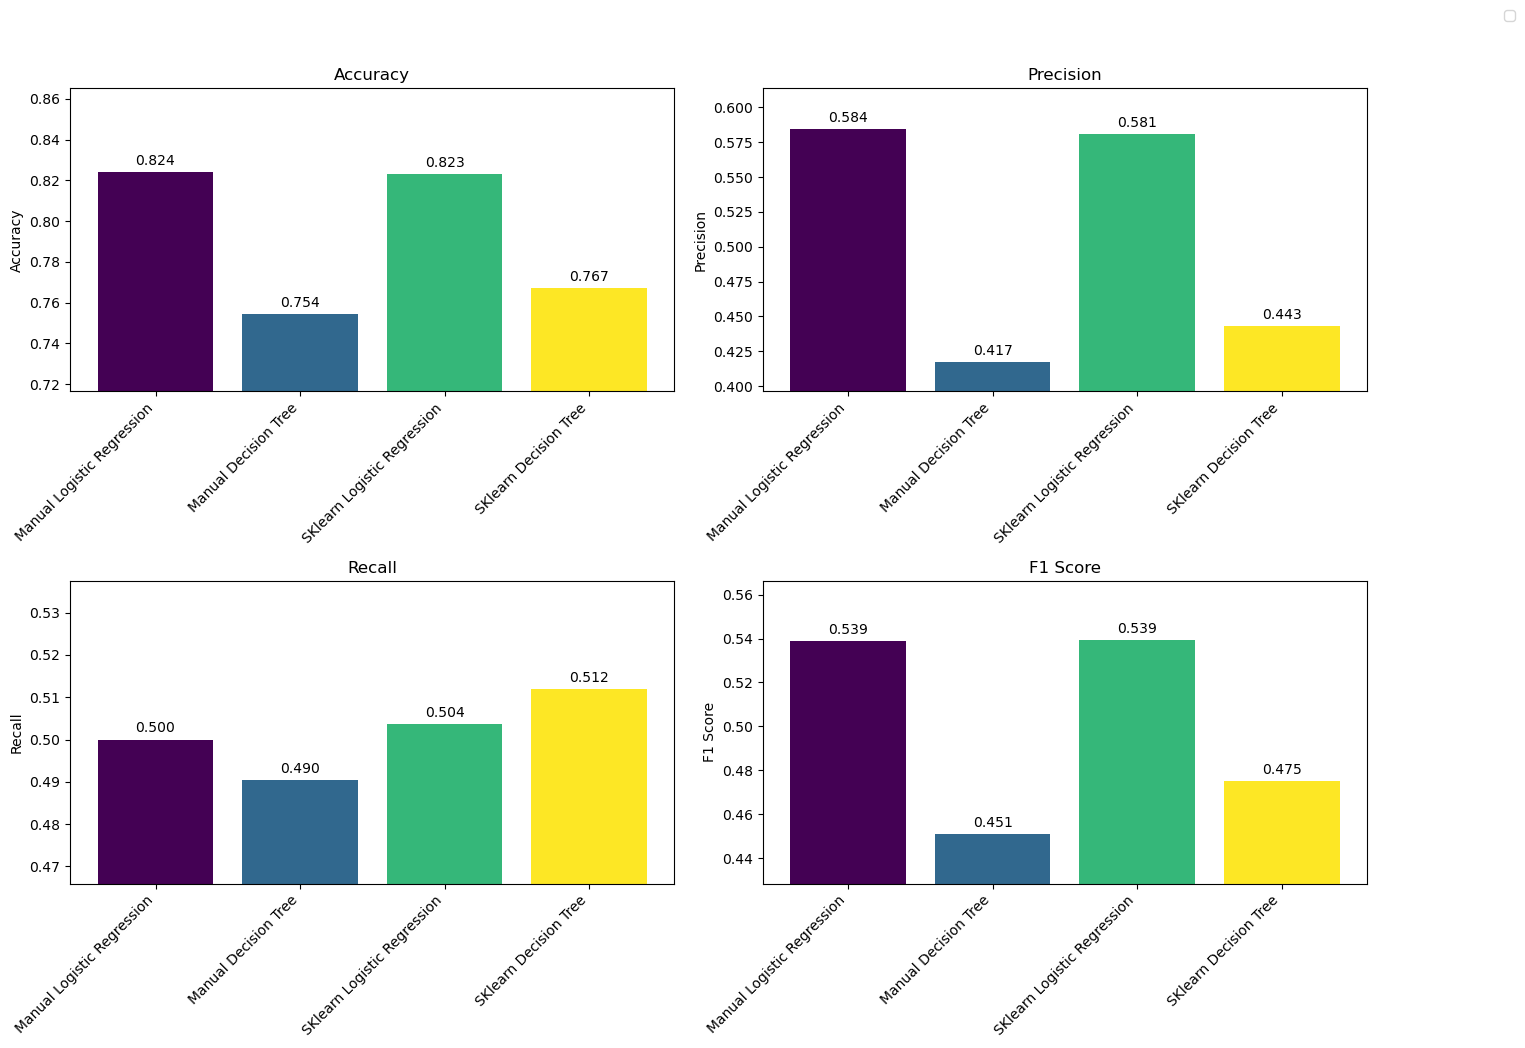

{'Manual Logistic Regression': Accuracy     0.823997
Precision    0.584434
Recall       0.500000
F1 Score     0.538930
dtype: float64, 'Manual Decision Tree': Accuracy     0.754281
Precision    0.417299
Recall       0.490488
F1 Score     0.450943
dtype: float64, 'SKlearn Logistic Regression': Model         Stacked
Accuracy     0.823019
Precision    0.580535
Recall       0.503567
F1 Score     0.539319
Name: 0, dtype: object, 'SKlearn Decision Tree': Model        SKlearn Logistic Regression
Accuracy                        0.767123
Precision                       0.442901
Recall                          0.511891
F1 Score                        0.474903
Name: 0, dtype: object}


In [ ]:
stacking_results = {
    'Manual Logistic Regression': metrics_logistic_regression[metrics_logistic_regression['Model'] == 'Stacked'].mean(numeric_only=True),
    'Manual Decision Tree': metrics_decision_tree[metrics_decision_tree['Model'] == 'Stacked'].mean(numeric_only=True),
    'SKlearn Logistic Regression': meta_model_metrics_lr.iloc[0],
    'SKlearn Decision Tree': meta_model_metrics_dt.iloc[0]
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
num_models = len(stacking_results)
colors = plt.cm.viridis(np.linspace(0, 1, num_models))

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for i, metric in enumerate(metrics):
    model_names = list(stacking_results.keys())
    metric_values = [stacking_results[model][metric] for model in model_names]

    bars = axes[i].bar(model_names, metric_values, color=colors)

    for bar, value in zip(bars, metric_values):
        height = bar.get_height()
        axes[i].annotate(f'{value:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    axes[i].set_ylim(min(metric_values) * 0.95, max(metric_values) * 1.05)
    axes[i].set_title(metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(len(model_names)))
    axes[i].set_xticklabels(model_names, rotation=45, ha='right')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()
plt.show()

print(stacking_results)

#### Analysis

The manual implementation of stacking with K fold seems to outperform that of sklearn. Looking at both implementations using logistic regression as the meta models, it can be seen that manual logistic regression has higher scores.

Using decision tree as a meta model only works better when we want to achieve a higher recall score. Else, logistic regression outperforms decision trees, likely due to its tendency to have less overfitting to training data.

### Comparing our manual ensemble model against the other classification models

In [15]:
metrics = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for model_info in models:
    model = model_info['model']
    selected_features = model_info['selected_features']
    model.fit(X_train[selected_features], Y_train.values.ravel())
    y_pred = model.predict(X_test[selected_features])
    metrics = pd.concat([metrics, pd.DataFrame.from_dict([{
                'Model': type(model).__name__, 
                'Accuracy': accuracy_score(Y_test,y_pred), 
                'Precision': precision_score(Y_test,y_pred), 
                'Recall': recall_score(Y_test,y_pred), 
                'F1 Score': f1_score(Y_test,y_pred)
            }])], ignore_index=True)

manual_stacked_logistic = metrics_logistic_regression[metrics_logistic_regression['Model'] == 'Stacked'].iloc[0]
metrics = pd.concat([metrics, pd.DataFrame.from_dict([{
    'Model': 'Stacked',
    'Accuracy': manual_stacked_logistic['Accuracy'],
    'Precision': manual_stacked_logistic['Precision'],
    'Recall': manual_stacked_logistic['Recall'],
    'F1 Score': manual_stacked_logistic['F1 Score']
}])], ignore_index=True)

In [ ]:
metrics

,Model,Accuracy,Precision,Recall,F1 Score
0,RandomForestClassifier,0.823386,0.582296,0.500595,0.538363
1,DecisionTreeClassifier,0.804428,0.525665,0.505351,0.515308
2,GradientBoostingClassifier,0.827911,0.595024,0.511891,0.550336
3,AdaBoostClassifier,0.822162,0.582489,0.478597,0.525457
4,LGBMClassifier,0.829990,0.602098,0.511891,0.553342
5,SVC,0.808464,0.535891,0.514863,0.525167
6,KNeighborsClassifier,0.787549,0.484113,0.498216,0.491064
7,LogisticRegression,0.809442,0.539092,0.508323,0.523256
8,Stacked,0.823997,0.584434,0.500000,0.538930


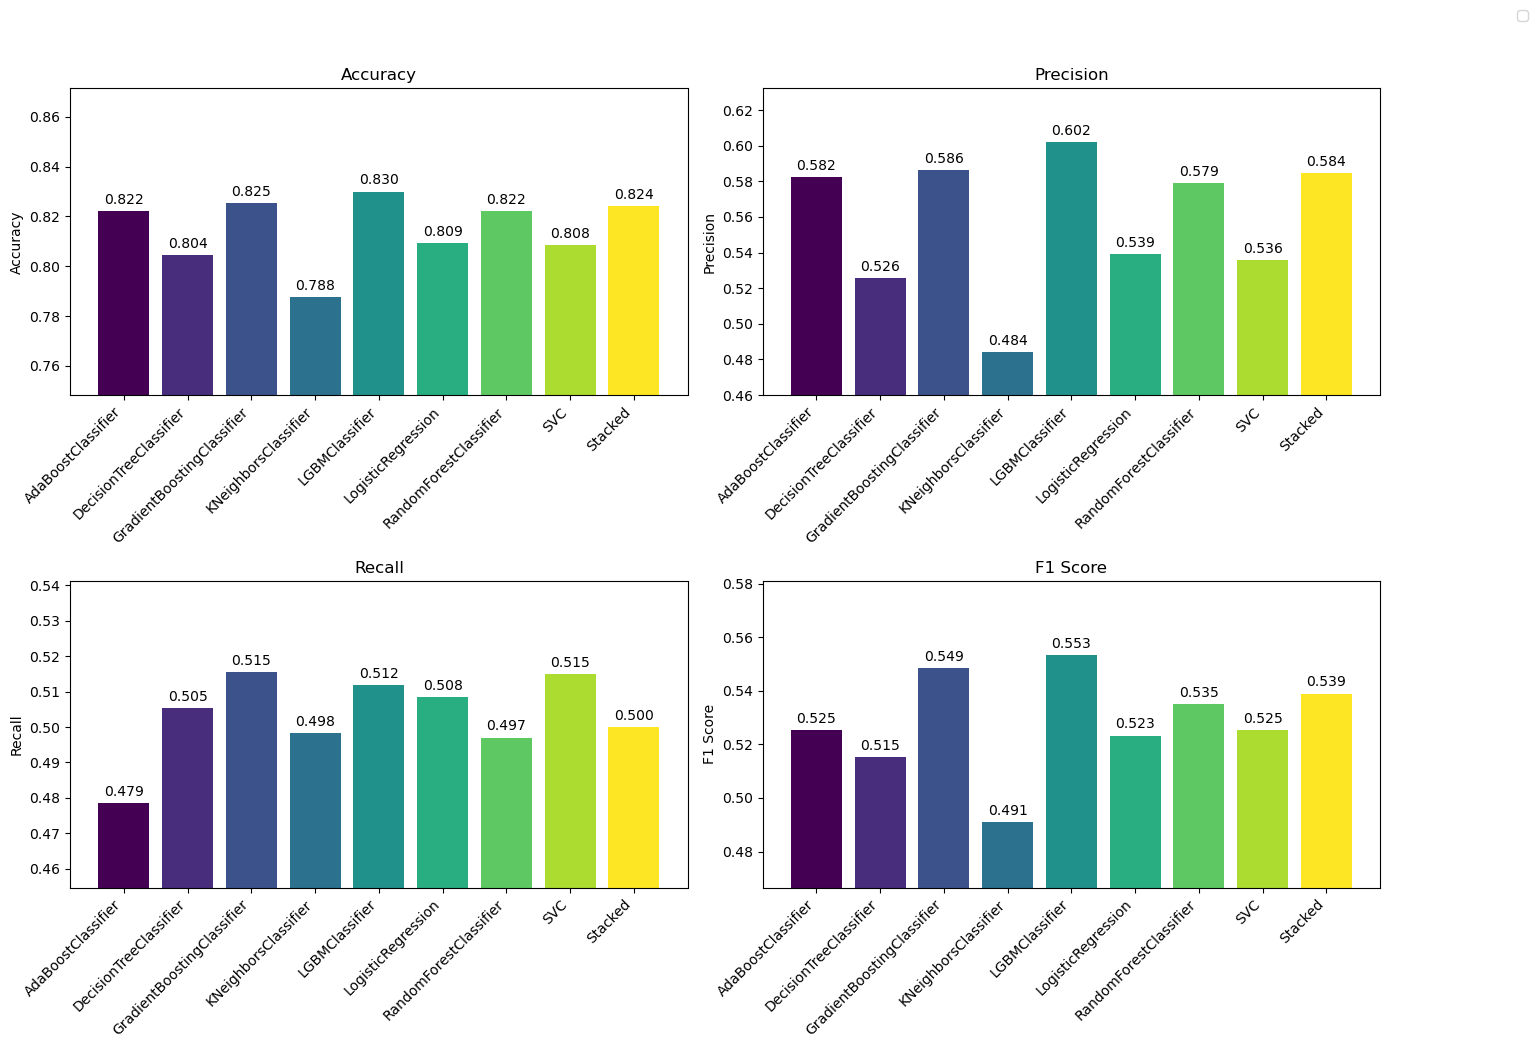

In [ ]:
print_model_comparison(metrics)

#### Overall Analysis of Comparing All the Different Models

Stacking typically enhances model performance by leveraging the strengths of individual models, but it doesn't guarantee superior results in every scenario. We can see that comparing the stacked meta model against the other classification models, it performed above average, but was not able to outperform GradientBoosting and LightGBM models.

Some other interesting comparisons here is that Logistic Regression was one of our best performing models when establishing the baseline models in the Notebook [4 - ClassificationModels.ipynb](/4%20-%20ClassificationModels.ipynb), but after feature engineering, feature selection, hyperparameter tuning and ensembling, we were able to obtain better models with higher accuracy and f1 scores. One hypothesis is that the dataset features are not the most optimised for linear seperability, especially in a high dimensional space, and hence other models were able to outperform it. Ensembling models such as bagging and boosting generally outperform the rest of the other classification models.

Overall, we can see that LightGBM model had the highest accuracy of 0.83 and the highest f1 score of 0.553, outperforming all the other models for predicting the cancellation. Hence, for our final model chosen for classification, we will employ LightGBM model for classifying whether if a hotel customer will honor the reservation or cancel it.



## Conclusion
### Other interesting findings (based on the overall project):
- Some attributes such as Lead Time, proved to be the most important in helping predict our data during the feature selection process (always kept by the different feature selection methods such as RFECV and Feature Importance). This observation was also in line with our findings in the data exploration stage where we discovered a high correlation between Lead Time and the Target Variable Cancelled.


- Feature Engineering and Boosting Techniques in particular led to big improvements in accuracy and f1 score as compared to baseline models.


- Our best model achieved  ~0.83 accuracy but only ~0.55 f1 score. We suspect this could be due to the quality of the data, as the features included may not be predictive enough to capture the dynamics of customer cancellations. 

## Future Recommendations:
1. <b>Reduce data imbalance by recording more samples</b>

The given dataset has some class imbalances and we made use of undersampling to remove the imbalance. But however, ideally the best way to do so is to record more samples with the minority label in order to reduce data imbalance.

2. <b>Leverage deep learning</b>

Leverage deep learning models for classification, especially since our dataset consists of a large number of features. Deep learning models can automatically extract and learn the best features and handle large dataset, which can potentially enhance the accuracy of our classification models

3. <b>Try new ways to remove anomalies and outliers</b>

Another possible improvement is to try to use other techniques to remove any outliers and anomalies such that our models are more generalizable. Some techniques includes using Isolation Forest, DBScan and LOF.

4. <b>Capture Additional Features and With Longer Timeframe of Data</b>

The given dataset spanned over the period of two years, which was not sufficient for feature engineering time-based data such as seasonality, which are known to have significant impacts on the hotel bookings based on different seasons.